In [2]:
import open_clip
from torchvision import datasets, transforms
import torch
from PIL import Image
import open_clip
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn import calibration
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn as nn
import torch.optim as optim
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.isotonic import IsotonicRegression as IR
from scipy.stats import norm
from tqdm import tqdm

/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from util import get_preds, calc_bins, get_metrics, T_scaling, find_temp_scale

In [8]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
batch_size = 128

In [9]:
def get_preds(model, tokenizer, dset, text_template='{}', temp_scaling=None):
    text = tokenizer([text_template.replace('{}',x) for x in dset.classes])
    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = model.encode_text(text.to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
    dataloader = DataLoader(dset, batch_size=batch_size, shuffle=False, num_workers=16)
    predictions = np.array([])
    actual = np.array([])
    probs = np.array([])
    for image, labels in dataloader:
        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(image.to(device))
            image_features /= image_features.norm(dim=-1, keepdim=True)
            if temp_scaling is not None:
                image_features = torch.div(image_features, temp_scaling)
            text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        vals, indics = text_probs.max(dim=1)
        predictions = np.append(predictions, indics.cpu().numpy())
        actual = np.append(actual, labels.numpy())
        probs = np.append(probs, vals.cpu().numpy())
    return predictions, actual, probs

In [10]:
def calc_bins(y_true, preds, confs, num_bins=10):
  # Assign each prediction to a bin
  bins = np.linspace(1.0 / num_bins, 1, num_bins)
  binned = np.digitize(confs, bins)

  # Save the accuracy, confidence and size of each bin
  bin_accs = np.zeros(num_bins)
  bin_confs = np.zeros(num_bins)
  bin_sizes = np.zeros(num_bins)

  for bin in range(num_bins):
    bin_sizes[bin] = len(preds[binned == bin])
    if bin_sizes[bin] > 0:
      bin_accs[bin] = np.mean(y_true[binned==bin] == preds[binned == bin])
      bin_confs[bin] = np.mean(confs[binned==bin])

  return bins, binned, bin_accs, bin_confs, bin_sizes

In [11]:
def get_metrics(y_true, preds, confs):
  ECE = 0
  MCE = 0
  bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(y_true, preds, confs)

  for i in range(len(bins)):
    abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
    ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
    MCE = max(MCE, abs_conf_dif)

  overall_acc = np.mean(y_true == preds)
  return ECE, MCE, overall_acc

In [12]:
model_name = 'ViT-B-32-quickgelu'
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained='laion400m_e32', device=device)
tokenizer = open_clip.get_tokenizer(model_name)
cifar_test = datasets.CIFAR10('/home/ubuntu/data/', train = False, transform = preprocess, download=True)

Files already downloaded and verified


In [36]:
cifar_test.classes = classes
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_to_append='')
#draw_reliability_graph(actual, predictions, probs, f"{model_name} - just class names")
get_metrics(predictions, actual, probs)

TypeError: get_preds() got an unexpected keyword argument 'text_to_append'

In [14]:
classes = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

templates = [
    '{}',
    'a photo of a {}.',
    'a blurry photo of a {}.',
    'a black and white photo of a {}.',
    'a low contrast photo of a {}.',
    'a high contrast photo of a {}.',
    'a bad photo of a {}.',
    'a good photo of a {}.',
    'a photo of a small {}.',
    'a photo of a big {}.',
    'a photo of the {}.',
    'a blurry photo of the {}.',
    'a black and white photo of the {}.',
    'a low contrast photo of the {}.',
    'a high contrast photo of the {}.',
    'a bad photo of the {}.',
    'a good photo of the {}.',
    'a photo of the small {}.',
    'a photo of the big {}.',
]
cifar_test.classes = classes

In [51]:
classes = [
    'apple',
    'aquarium fish',
    'baby',
    'bear',
    'beaver',
    'bed',
    'bee',
    'beetle',
    'bicycle',
    'bottle',
    'bowl',
    'boy',
    'bridge',
    'bus',
    'butterfly',
    'camel',
    'can',
    'castle',
    'caterpillar',
    'cattle',
    'chair',
    'chimpanzee',
    'clock',
    'cloud',
    'cockroach',
    'couch',
    'crab',
    'crocodile',
    'cup',
    'dinosaur',
    'dolphin',
    'elephant',
    'flatfish',
    'forest',
    'fox',
    'girl',
    'hamster',
    'house',
    'kangaroo',
    'keyboard',
    'lamp',
    'lawn mower',
    'leopard',
    'lion',
    'lizard',
    'lobster',
    'man',
    'maple tree',
    'motorcycle',
    'mountain',
    'mouse',
    'mushroom',
    'oak tree',
    'orange',
    'orchid',
    'otter',
    'palm tree',
    'pear',
    'pickup truck',
    'pine tree',
    'plain',
    'plate',
    'poppy',
    'porcupine',
    'possum',
    'rabbit',
    'raccoon',
    'ray',
    'road',
    'rocket',
    'rose',
    'sea',
    'seal',
    'shark',
    'shrew',
    'skunk',
    'skyscraper',
    'snail',
    'snake',
    'spider',
    'squirrel',
    'streetcar',
    'sunflower',
    'sweet pepper',
    'table',
    'tank',
    'telephone',
    'television',
    'tiger',
    'tractor',
    'train',
    'trout',
    'tulip',
    'turtle',
    'wardrobe',
    'whale',
    'willow tree',
    'wolf',
    'woman',
    'worm',
]

templates = [
    '{}',
    'a photo of a {}.',
    'a blurry photo of a {}.',
    'a black and white photo of a {}.',
    'a low contrast photo of a {}.',
    'a high contrast photo of a {}.',
    'a bad photo of a {}.',
    'a good photo of a {}.',
    'a photo of a small {}.',
    'a photo of a big {}.',
    'a photo of the {}.',
    'a blurry photo of the {}.',
    'a black and white photo of the {}.',
    'a low contrast photo of the {}.',
    'a high contrast photo of the {}.',
    'a bad photo of the {}.',
    'a good photo of the {}.',
    'a photo of the small {}.',
    'a photo of the big {}.',
]
cifar_test.classes = classes

In [15]:
eces = []
mces = []
accs = []
for t in tqdm(templates):
    predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t)
    ece, mce, acc = get_metrics(predictions, actual, probs)
    eces.append(ece)
    accs.append(acc)
    mces.append(mce)

100%|██████████| 19/19 [02:12<00:00,  6.98s/it]


Text(0.5, 1.0, 'ECE for different templates - ViT-B-32-quickgelu, CIFAR10')

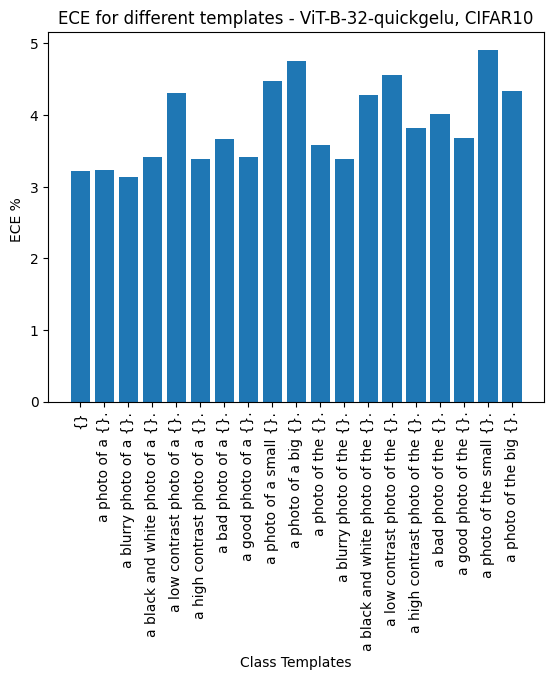

In [28]:
plt.bar(templates, np.array(eces) * 100.0)
plt.xticks(rotation=90)
plt.ylabel('ECE % ')
plt.xlabel('Class Templates')
plt.title(f'ECE for different templates - {model_name}, CIFAR10')

Text(0.5, 1.0, 'Accuracy for different templates - ViT-B-32-quickgelu, CIFAR10')

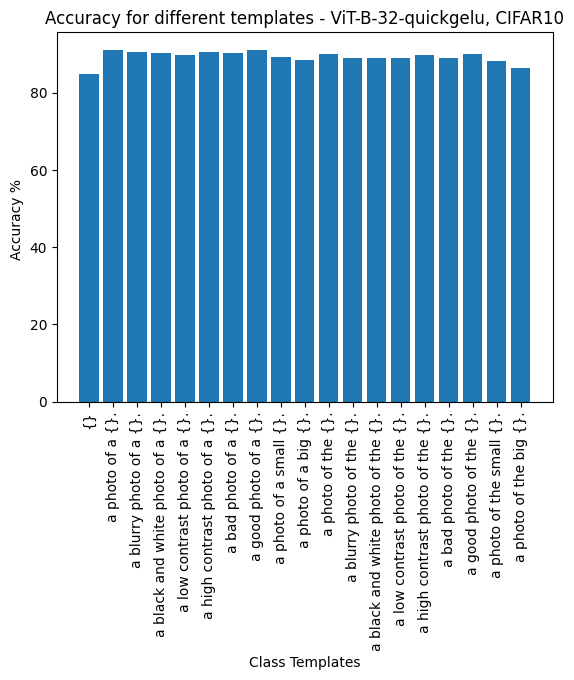

In [29]:
plt.bar(templates, np.array(accs) * 100.0)
plt.xticks(rotation=90)
plt.ylabel('Accuracy % ')
plt.xlabel('Class Templates')
plt.title(f'Accuracy for different templates - {model_name}, CIFAR10')

Text(0.5, 1.0, 'MCE for different templates - ViT-B-32-quickgelu, CIFAR10')

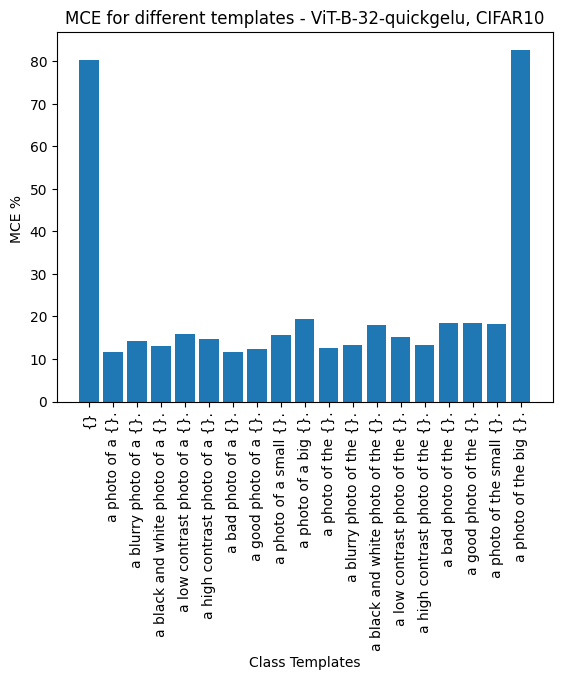

In [30]:
plt.bar(templates, np.array(mces) * 100.0)
plt.xticks(rotation=90)
plt.ylabel('MCE % ')
plt.xlabel('Class Templates')
plt.title(f'MCE for different templates - {model_name}, CIFAR10')

In [19]:
def T_scaling(logits, args):
  temperature = args.get('temperature', None)
  return torch.div(logits, temperature)

In [22]:
def find_temp_scale_run(model, val_dset, q, num_classes=100, text_template='{}'):
    ## Get all text features
    text = tokenizer([text_template.replace('{}',x) for x in val_dset.classes])
    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = model.encode_text(text.to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)

    ## Get all image features
    val_loader = DataLoader(val_dset, batch_size=batch_size, shuffle=False)
    all_val_img_features = None
    for i, data in enumerate(val_loader, 0):
        images = data[0].to(device)
        model.eval()
        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            if all_val_img_features is None:
                all_val_img_features = image_features
            else:
                all_val_img_features = torch.concat([all_val_img_features, image_features])
    
    ## Get text probs
    text_probs = (100.0 * all_val_img_features @ text_features.T)
    
    ## Get threshold
    #q = 1 - (1 / num_classes) * 1.5
    text_probs_numpy = text_probs.cpu().numpy()
    thresholds = norm.ppf(q, loc=np.mean(text_probs_numpy, axis=1), scale = np.std(text_probs_numpy, axis=1))
    
    ## Setup LBGFS
    temperature = nn.Parameter((torch.ones(1)).to(device))
    args = {'temperature': temperature}
    criterion = nn.CrossEntropyLoss()

    # Removing strong_wolfe line search results in jump after 50 epochs
    optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=1000, line_search_fn='strong_wolfe')

    logits_list = []
    labels_list = []
    for k in range(len(text_probs_numpy)):
      for j in range(len(text_probs_numpy[0])):
          if text_probs_numpy[k][j] >= thresholds[k]:
            logits_list.append(np.expand_dims(text_probs_numpy[k],0))
            labels_list.append(j)
    logits_list = torch.cat(logits_list).to(device) # [len(dset), 100]
    labels_list = torch.FloatTensor(labels_list).to(device).long()

    temps = []
    losses = []
    def _eval():
        loss = criterion(T_scaling(logits_list, args), labels_list)
        loss.backward()
        temps.append(temperature.item())
        losses.append(loss)
        return loss

    optimizer.step(_eval)
    return temperature.item()

With temperature scaling

In [20]:
def get_val_set(val_transform):
    cifar_train = datasets.CIFAR10('/home/ubuntu/data/', train = True, transform = val_transform, download=True)
    np.random.seed(0)
    cifar_val = (torch.utils.data.Subset(cifar_train, np.random.randint(0, len(cifar_train), 10000)))
    cifar_val.classes = classes
    return cifar_val
cifar_val = get_val_set(preprocess)

Files already downloaded and verified


In [68]:
eces = []
mces = []
accs = []
temps = []
for t in tqdm(templates):
    scaled_temp = find_temp_scale(model, cifar_val, text_template=t)
    temps.append(scaled_temp)
    predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, temp_scaling=scaled_temp)
    ece, mce, acc = get_metrics(predictions, actual, probs)
    eces.append(ece)
    accs.append(acc)
    mces.append(mce)

 37%|███▋      | 7/19 [08:54<15:13, 76.16s/it]

In [21]:
test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False)
all_test_img_features = None
all_test_labels = None
for i, data in enumerate(tqdm(test_loader, 0)):
    #images, labels = data[0].to(device), data[1].to(device)
    images = data[0].to(device)

    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        if all_test_img_features is None:
            all_test_img_features = image_features
            all_test_labels = data[1]
        else:
            all_test_img_features = torch.concat([all_test_img_features, image_features])
            all_test_labels = torch.concat([all_test_labels, data[1]])
all_test_img_features.shape

100%|██████████| 79/79 [00:20<00:00,  3.91it/s]


torch.Size([10000, 512])

In [22]:
val_loader = DataLoader(cifar_val, batch_size=batch_size, shuffle=False)
all_val_img_features = None
for i, data in enumerate(tqdm(val_loader, 0)):
    #images, labels = data[0].to(device), data[1].to(device)
    images = data[0].to(device)

    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        if all_val_img_features is None:
            all_val_img_features = image_features
        else:
            all_val_img_features = torch.concat([all_val_img_features, image_features])
all_val_img_features.shape

100%|██████████| 79/79 [00:17<00:00,  4.49it/s]


torch.Size([10000, 512])

In [42]:
assert cifar_test.classes == classes
text = tokenizer([templates[3].replace('{}',x) for x in classes])
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = model.encode_text(text.to(device))
    text_features /= text_features.norm(dim=-1, keepdim=True)
text_features.shape

torch.Size([10, 512])

In [43]:
text_probs_test = (100.0 * all_test_img_features @ text_features.T)
text_probs_val = (100.0 * all_val_img_features @ text_features.T)

In [44]:
def get_preds_feats(temp_scaling):#, text_template):
    #text = tokenizer([text_template.replace('{}',x) for x in classes])
    #with torch.no_grad(), torch.cuda.amp.autocast():
    #    text_features = model.encode_text(text.to(device))
    #    text_features /= text_features.norm(dim=-1, keepdim=True)
        
    image_features = torch.div(all_test_img_features, temp_scaling)
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    probs, predictions = text_probs.max(dim=1)
    return probs.cpu().numpy(), predictions.cpu().numpy()

In [61]:
def find_temp_scal_range(q):
  temperature = nn.Parameter((torch.ones(1)).to(device))
  args = {'temperature': temperature}
  criterion = nn.CrossEntropyLoss()

  logits_list = []
  labels_list = []
  temps = []
  losses = []
  # Removing strong_wolfe line search results in jump after 50 epochs
  optimizer = optim.LBFGS([temperature], lr=0.01, max_iter=70, line_search_fn='strong_wolfe')
  #thresholds = torch.quantile(text_probs.float(), q, axis=1)
  #thresholds = torch.mean(text_probs, axis=1) + q * torch.std(text_probs, axis=1)
  text_probs_numpy = text_probs_val.float().cpu().numpy()
  '''cdf = np.cumsum(text_probs_numpy, axis=1) / np.expand_dims(np.sum(text_probs_numpy, axis=1), 1)
  thresholds = np.zeros(len(cdf), dtype=float)
  for i, ind in enumerate(np.argmin(np.abs(cdf-q), axis=1)):
      thresholds[i] = text_probs_numpy[i][ind]'''

  thresholds = norm.ppf(q, loc=np.mean(text_probs_numpy, axis=1), scale = np.std(text_probs_numpy, axis=1))
  all_cts = []
  for k in range(len(text_probs_numpy)):
      for j in range(len(text_probs_numpy[0])):
          if text_probs_numpy[k][j] >= thresholds[k]:
            logits_list.append(text_probs_val[k].unsqueeze(0))
            labels_list.append(j)

  #print(np.unique(all_cts, return_counts=True))
  #print(np.mean(np.array(cts)))
  logits_list = torch.cat(logits_list).to(device) # [len(dset), 100]
  labels_list = torch.FloatTensor(labels_list).to(device).long()

  def _eval():
    loss = criterion(T_scaling(logits_list, args), labels_list)
    loss.backward()
    temps.append(temperature.item())
    losses.append(loss)
    return loss


  optimizer.step(_eval)
  return temperature.item()

In [45]:
def find_temp_scal_quantile(q):
  temperature = nn.Parameter((torch.ones(1)).to(device))
  args = {'temperature': temperature}
  criterion = nn.CrossEntropyLoss()

  logits_list = []
  labels_list = []
  temps = []
  losses = []
  # Removing strong_wolfe line search results in jump after 50 epochs
  optimizer = optim.LBFGS([temperature], lr=0.01, max_iter=70, line_search_fn='strong_wolfe')
  #thresholds = torch.quantile(text_probs.float(), q, axis=1)
  #thresholds = torch.mean(text_probs, axis=1) + q * torch.std(text_probs, axis=1)
  text_probs_numpy = text_probs_val.cpu().numpy()
  '''cdf = np.cumsum(text_probs_numpy, axis=1) / np.expand_dims(np.sum(text_probs_numpy, axis=1), 1)
  thresholds = np.zeros(len(cdf), dtype=float)
  for i, ind in enumerate(np.argmin(np.abs(cdf-q), axis=1)):
      thresholds[i] = text_probs_numpy[i][ind]'''
  confidences_of_js = np.sort(text_probs_numpy, axis=0)
  for k in range(len(text_probs_numpy)):
      for j in range(len(text_probs_numpy[0])):
          confidences_of_j = confidences_of_js[:,j]
          #assert np.array_equal(sorted(text_probs_numpy[:, j]) , confidences_of_j)
          thresh = confidences_of_j[int(len(confidences_of_j) * q)] 
          if text_probs_numpy[k][j] >= thresh:
            logits_list.append(text_probs_val[k].unsqueeze(0))
            labels_list.append(j)

  #print(np.unique(all_cts, return_counts=True))
  #print(np.mean(np.array(cts)))
  logits_list = torch.cat(logits_list).to(device) # [len(dset), 100]
  labels_list = torch.FloatTensor(labels_list).to(device).long()

  def _eval():
    loss = criterion(T_scaling(logits_list, args), labels_list)
    loss.backward()
    temps.append(temperature.item())
    losses.append(loss)
    return loss


  optimizer.step(_eval)
  return temperature.item()

In [46]:
temps = []
eces = []
x_axis = np.arange(0.8, 0.999, 0.01)
for q in tqdm(x_axis):
    scaled_temp = find_temp_scal_quantile(q)
    #predictions, actual, probs = get_preds(model, tokenizer, cifar_test,  text_to_append='', temp_scaling=scaled_temp)
    probs, predictions = get_preds_feats(scaled_temp)
    ECE, MCE,ac = get_metrics(predictions, all_test_labels.cpu().numpy(), probs)
    temps.append(scaled_temp)
    eces.append(ECE * 100)

100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


In [48]:
scaled_temp = find_temp_scal_quantile(1 - 0.83/10)
#predictions, actual, probs = get_preds(model, tokenizer, cifar_test,  text_to_append='', temp_scaling=scaled_temp)
probs, predictions = get_preds_feats(scaled_temp)
ECE, MCE,ac = get_metrics(predictions, all_test_labels.cpu().numpy(), probs)
ECE, MCE, ac, scaled_temp

(0.15080064697265622, 0.25074875842239774, 0.903, 2.8641231060028076)

Text(0.5, 1.0, 'A photo of - zoomed in')

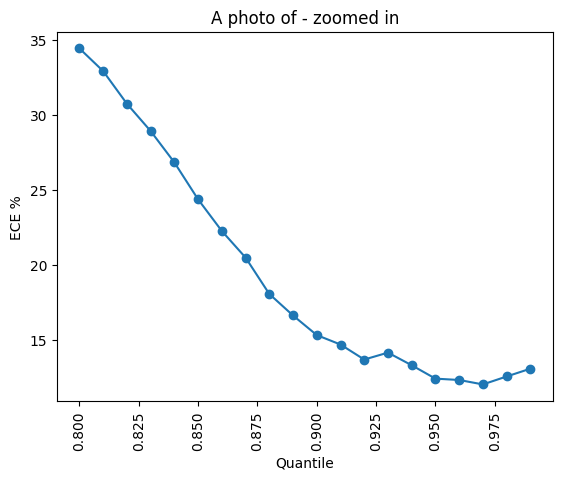

In [47]:
#plt.plot(x_axis, temps, label='Temperature')
plt.plot(x_axis, np.array(eces), marker='o',label='ECE %')
plt.xticks(rotation=90)
plt.xlabel('Quantile')
plt.ylabel('ECE %')
plt.title('A photo of - zoomed in')

100%|██████████| 19/19 [00:25<00:00,  1.36s/it]


Text(0.5, 1.0, 'Temperature vs ECE')

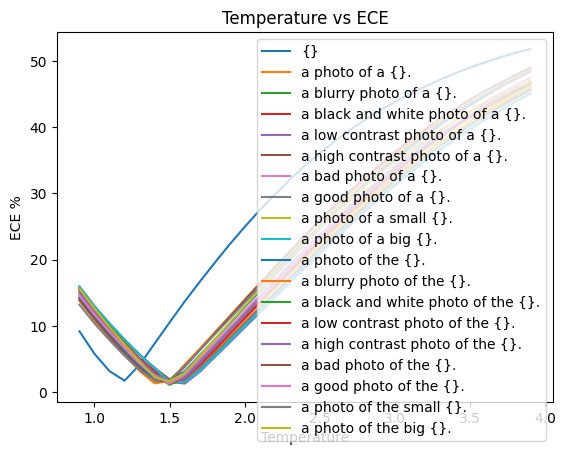

In [43]:
temps = np.arange(0.9, 4, 0.1)
for t in tqdm(templates):
    eces = []
    for scaled_temp in temps:
        probs, predictions = get_preds_feats(scaled_temp, t)
        ECE, MCE, acc = get_metrics(predictions, all_test_labels.cpu().numpy(), probs)
        eces.append(ECE * 100)
    plt.plot(temps, eces, label=t)
plt.legend()
plt.ylabel('ECE %')
plt.xlabel('Temperature')
plt.title('Temperature vs ECE')

  0%|          | 0/600 [00:00<?, ?it/s]/home/ubuntu/code/clip_miscalibration/util.py:56: RuntimeWarning: invalid value encountered in double_scalars
  ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
100%|██████████| 600/600 [00:01<00:00, 390.40it/s]


Text(0.5, 1.0, 'Temperature vs ECE - Zoomed in')

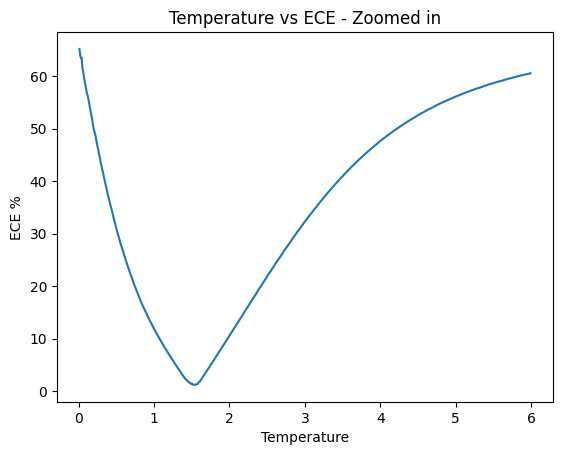

In [20]:
eces = []
temps = np.arange(0, 6, 0.01)
for scaled_temp in tqdm(temps):
    probs, predictions = get_preds_feats(scaled_temp)
    ECE, MCE, acc = get_metrics(predictions, all_test_labels.cpu().numpy(), probs)
    eces.append(ECE * 100)
plt.plot(temps, eces)
plt.ylabel('ECE %')
plt.xlabel('Temperature')
plt.title('Temperature vs ECE - Zoomed in')